In [2]:
# Set environment variables 
import os
os.environ["MY_NUMBA_TARGET"] = "cuda"
os.environ["GAUGE_GROUP"] = "su2"
os.environ["PRECISION"] = "double"

# Import curraun and other packages
import sys
sys.path.append('..')

import curraun.core as core
import curraun.mv as mv
import curraun.kappa as kappa
import curraun.qhat as qhat
from curraun.energy import Energy
import curraun.initial as initial
initial.DEBUG = False

from curraun.numba_target import use_cuda, use_numba
if use_cuda:
    from numba import cuda

import numpy as np
import pickle, datetime
from tqdm import tqdm

import matplotlib.pyplot as plt

from matplotlib import rc
rc('text', usetex=True)
plt.rcParams["figure.figsize"] = (10, 7)
plt.rcParams.update({'font.size':18})

# define hbar * c in units of GeV * fm
hbarc = 0.197326 

Using CUDA
Using SU(2)
Using double precision
Using double precision


In [3]:
def compute(p):    
    # output dictionary
    output = {}
    output["p_qhat"] = []
    output["p_kappa"] = []
    output["energy"] = []
    
    output["EL"] = []
    output["BL"] = []
    output["ET"] = []
    output["BT"] = []
    
    output["pL"] = []
    output["pT"] = []
    
    # derived parameters
    a = p['L'] / p['N']
    E0 = p['N'] / p['L'] * hbarc
    DT = 1.0 / p['DTS']
    maxt = int(p['TMAX'] / a) * p['DTS']
    
    # event loop
    for e in range(p['NE']):
        # initialization
        # print("Initializating ...")
        s = core.Simulation(p['N'], DT, p['G'])
        va = mv.wilson(s, mu=p['MU'] / E0, m=p['M'] / E0, uv=p['UV'] / E0, num_sheets=p['NS'])
        vb = mv.wilson(s, mu=p['MU'] / E0, m=p['M'] / E0, uv=p['UV'] / E0, num_sheets=p['NS'])
        initial.init(s, va, vb)

        # print("Memory of data: {} GB".format(s.get_ngb()))

        # initialize transport computation
        kappa_tforce = kappa.TransportedForce(s)
        qhat_tforce = qhat.TransportedForce(s)
        
        # initialize energy computation
        en = Energy(s)

        # temporary results
        p_qhat = []
        p_kappa = []
        
        EL = []
        BL = []
        ET = []
        BT = []
        
        energy = []
        pL = []
        pT = []

        if use_cuda:
            s.copy_to_device()
            kappa_tforce.copy_to_device()
            qhat_tforce.copy_to_device()

            meminfo = cuda.current_context().get_memory_info()
            # print("CUDA free memory: {:.2f} GB of {:.2f} GB.".format(meminfo[0] / 1024 ** 3, meminfo[1] / 1024 ** 3))
        
        with tqdm(total=maxt, file=sys.stdout, miniters=128) as pbar:
            for t in range(maxt):
                core.evolve_leapfrog(s)
                
                if t % p['DTS'] == 0:
                    if use_cuda:
                        # Copy data from device to host
                        kappa_tforce.copy_mean_to_host()
                        qhat_tforce.copy_mean_to_host()

                    # unit factors (GeV^2)
                    units = E0 ** 2 / (s.g ** 2)

                    # color factors (for quarks)
                    Nc = core.su.NC
                    f = 2 * s.g ** 2 / (2 * Nc)

                    p_qhat.append(qhat_tforce.p_perp_mean * units * f)
                    p_kappa.append(kappa_tforce.p_perp_mean * units * f)

                    # Energy density calculation
                    en.compute()
                    
                    # unit factors (GeV^3)
                    units = E0 ** 3
                    EL.append(en.EL_mean * units)
                    BL.append(en.BL_mean * units)
                    ET.append(en.ET_mean * units)
                    BT.append(en.BT_mean * units)
                    
                    # unit factors (Gev / fm^3)
                    units = E0 ** 4 / hbarc ** 3
                    energy.append(en.energy_density * units)
                    pL.append(en.pL * units)
                    pT.append(en.pT * units)
                    
                    if use_cuda:
                        # Copy data back to device
                        kappa_tforce.copy_mean_to_device()
                        qhat_tforce.copy_mean_to_device()

                kappa_tforce.compute()
                qhat_tforce.compute()

                pbar.set_description('Event {:3d} | {:.2f} GB / {:.2f} GB'.format(e,
                                                                                  meminfo[0] / 1024 ** 3,
                                                                                  meminfo[1] / 1024 ** 3))
                pbar.update(1)
        
        p_qhat = np.array(p_qhat)     
        p_kappa = np.array(p_kappa)
        energy = np.array(energy)
        
        EL = np.array(EL)
        BL = np.array(BL)
        ET = np.array(ET)
        BT = np.array(BT)
        
        pL = np.array(pL)
        pT = np.array(pT)

        output["p_qhat"].append(p_qhat)
        output["p_kappa"].append(p_kappa)
        output["energy"].append(energy)
        
        output["EL"].append(EL)
        output["BL"].append(BL)
        output["ET"].append(ET)
        output["BT"].append(BT)
        
        output["pL"].append(pL)
        output["pT"].append(pT)
    
    # perform average over events
    
    # also add standard deviations
    output["p_qhat_std"] = np.std(np.array(output["p_qhat"]), axis=0)
    output["p_kappa_std"] = np.std(np.array(output["p_kappa"]), axis=0)
    output["energy_std"] = np.std(np.array(output["energy"]), axis=0)
    
    output["EL_std"] = np.std(np.array(output["EL"]), axis=0)
    output["BL_std"] = np.std(np.array(output["BL"]), axis=0)
    output["ET_std"] = np.std(np.array(output["ET"]), axis=0)
    output["BT_std"] = np.std(np.array(output["BT"]), axis=0)
    
    output["pL_std"] = np.std(np.array(output["pL"]), axis=0)
    output["pT_std"] = np.std(np.array(output["pT"]), axis=0)
    
    # compute means
    output["p_qhat"] = np.mean(np.array(output["p_qhat"]), axis=0)
    output["p_kappa"] = np.mean(np.array(output["p_kappa"]), axis=0)
    output["energy"] = np.mean(np.array(output["energy"]), axis=0)
    
    output["EL"] = np.mean(np.array(output["EL"]), axis=0)
    output["BL"] = np.mean(np.array(output["BL"]), axis=0)
    output["ET"] = np.mean(np.array(output["ET"]), axis=0)
    output["BT"] = np.mean(np.array(output["BT"]), axis=0)
    
    output["pL"] = np.mean(np.array(output["pL"]), axis=0)
    output["pT"] = np.mean(np.array(output["pT"]), axis=0)
    
    # more useful stuff
    output["tau"] = np.linspace(0, p['TMAX'], num=int(p['TMAX'] / a))
    output["E0"] = E0
    
    if use_cuda:
        cuda.current_context().deallocations.clear()
    
    return output

In [4]:
def run_simulation_weak(m_ratio, tmax, g, fn):
    m = 1.0                       # GeV
    Q = m / m_ratio               # GeV
    mu = Q / (g ** 2)             # GeV
    R = 1.0 / m * hbarc           # fm
    R_Q = 1.0 / Q * hbarc         # fm
    tmax_fm = tmax / m * hbarc    # fm
    L = 25.0 / m * hbarc          # fm
    
    p = {
        'L':    25.0 / m * hbarc, # transverse size [fm]
        'N':    1024,             # lattice size
        'DTS':  16,               # time steps per transverse spacing
        'TMAX': tmax_fm,          # max. proper time (tau) [fm]

        'G':    g,                # YM coupling constant
        'MU':   mu,               # MV model parameter [GeV]
        'M':    m,                # IR regulator [GeV]
        'UV':   1000000.0,        # UV regulator [GeV]
        'NS':   50,               # number of color sheets

        'NE':   20,               # number of events
    }
    print("g^2 \mu = {} m using g = {}".format(g ** 2 * mu, g))
    print("IR radius = {} / m".format(R))
    print("Q radius = {} / m".format(R_Q))
    print("Box size = {} / m".format(p['L']))
    print("Max tau = {} / m".format(tmax_fm))
    
    res = compute(p)
    pickle.dump(res, open("./{}.pickle".format(fn), "wb"))

In [ ]:
m_ratios = [100.0]
tmax = 10.0 # in units of m^{-1}
g = 2.0

for mr in m_ratios:
    fn = "m_Qs_ratio_su2_{:3.2f}".format(mr)
    print("Output: {}".format(fn))
    run_simulation_weak(mr, tmax, g, fn)

Output: m_Qs_ratio_su2_100.00
g^2 \mu = 0.01 m using g = 2.0
IR radius = 0.197326 / m
Q radius = 19.7326 / m
Box size = 4.93315 / m
Max tau = 1.97326 / m
Event   0 | 9.41 GB / 11.78 GB:  51%|█████     | 3331/6544 [00:13<00:09, 343.48it/s]

In [5]:
m_ratios = [100.0]
fns = ["m_Qs_ratio_su2_{:3.2f}".format(mr) for mr in m_ratios]
ress = []
for fn in fns:
    res = pickle.load(open("./{}.pickle".format(fn), "rb"))
    ress.append(res)

In [6]:
len(ress)

1

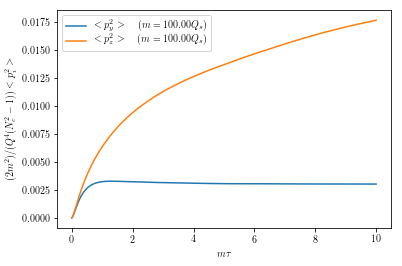

In [7]:
Nc = core.su.NC
c = 0.5 * (Nc ** 2 - 1)
m_ratios = [100.0]
for i, r in enumerate(ress):
    Q = 1.0 / m_ratios[i]
    plt.plot(r["tau"] / hbarc, r["p_qhat"][:, 1] / Q ** 4 / c,
             label="$<p_y^2> \quad (m = {:3.2f} Q_s)$".format(m_ratios[i]))
    plt.plot(r["tau"] / hbarc, r["p_qhat"][:, 2] / Q ** 4 / c,
             label="$<p_z^2> \quad (m = {:3.2f} Q_s)$".format(m_ratios[i]))

plt.xlabel("$m \\tau$")
plt.ylabel("$( 2 m^2 )/(Q^4 (N_c^2 - 1)) <p_i^2> $")
#plt.xlim([0, 1])
#plt.ylim([0, 0.005])
plt.legend()

In [8]:
# Create some tables for pgfplots
unit_factor = 1.0 / (Q ** 4 * c)
m_ratios = [100.0]
r = ress[0]
data = [r["tau"] / hbarc]
Q = 1.0 / m_ratios[0]
data.append(r["p_qhat"][:, 1] * unit_factor)
data.append(r["p_qhat"][:, 2] * unit_factor)
data = np.array(data).T
data = np.nan_to_num(data)

np.savetxt("psquared_weak_su2.dat", data, header="m * tau, m^2 <p^2_y> / (Q^4 * c), m^2 <p^2_z> / (Q^4 * c)")

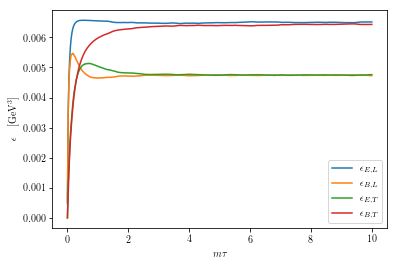

In [17]:
# Let's take a look at energy densities
Q = 1.0 / m_ratios[0]
r = ress[0]
Nc = 2
g = 2
f =  g ** 2/ (0.5 * Q ** 4 * Nc * (Nc ** 2 - 1))
plt.plot(r["tau"] / hbarc, r["EL"] * f)
plt.plot(r["tau"] / hbarc, r["BL"] * f)
plt.plot(r["tau"] / hbarc, r["ET"] * f)
plt.plot(r["tau"] / hbarc, r["BT"] * f)
#plt.ylim([0,0.000000005])
#plt.xlim([0, 2.0])
plt.xlabel("$m \\tau$")
plt.ylabel("$\epsilon \quad [ \mathrm{GeV}^3 ]$")
plt.legend(["$\epsilon_{E, L}$", "$\epsilon_{B, L}$", "$\epsilon_{E, T}$", "$\epsilon_{B, T}$"])